In [77]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [78]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte da validação do dataset
valset = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

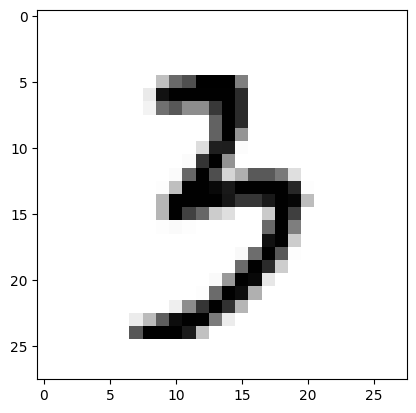

In [79]:
dataiter = iter(trainloader);
imagens, etiquetas = next(dataiter);
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [80]:
print(imagens[0].shape) # Para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # Para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [81]:
class Modelo(nn.Module):
    def _init_(self):
        super(Modelo, self)._init_()
        self.linear1 = nn.Linear(28*28, 128) # Camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # Camada interna 1, 128 nuerônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # Camada interna 2, 64 nuerônios que se ligam a 10
        # para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self,x):
        x = F.relu(self.linear1(x)) # Função de ativação da camada de entrada para a camada interna 1
        x = F.relu(self.linear2(x)) # Função de ativação da camada interna 1 para a camada interna 2
        x = self.linear3(x) # Função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(x, dim=1) # Dados utilizamos para calcular a perda



In [82]:
def treino (modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # Define a política de atualização dos pesos e da bias
    inicio = time() # Timer para sabermos quanto tempo levou o treino

    criterio = nn.NLLLoss # Definido o critério para calcular a perda
    EPOCHS = 10 # Numero de epochs que o algoritmo rodará
    modelo.train() #Ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):

        perda_acumulada = 0 # Inicialização da perda acumuladada epoch em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens[0], -1) # Convertendo as imagens para "vetores" de 28*28 casas para ficarem compativeis
            otimizador.zero_grad() # Zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) # Colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # Calculando a perda da epcoh em questão

            perda_instantanea.backward() # Back propagation a partir da perda

            otimizador.step() # Atualizando os pesos e a bias

            perda_acumulada += perda_instantanea.item() # Atualização da perda acumulada

        else:
            print("Epoch {} - Perda Resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
            print("\nTempo de Treino (em minutos) =", (time()-inicio)/60)

In [83]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
      for i in range(len(etiquetas)):
        img = imagens[i].view(1, 784)
        # Desativa o autograd para acelerar a validação. GRAFOS COMPUTACIONAIS DINÂMICOS tem um custo alto de processamento
        with torch.no_grad():
            logps = modelo(img.to(device)) # Output do modelo em escala logaritmica

        ps = torch.exp(logps) # Converte output para escala normal(lembrando que é um tensor)
        probab = list(ps.cpu().numpy()[0])
        etiqueta_pred = probab.index(max(probab)) # Converte o tensor em um número, no caso, o número que o modelo previu
        etiqueta_certa = etiquetas.numpy()[i]

        if(etiqueta_certa == etiqueta_pred): # Compara a previsão com o valor correto
          conta_corretas += 1
          conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))


In [84]:
modelo = Modelo() # Inicializa o modelo
device = torch.device("cuda" if torch.cuda.is_available else "cpu") # Modelo rodará na CPU se possível
modelo.to(device)

Modelo()